Setup the environment
===
- Install the required packages
- Import the required libraries

In [2]:
%pip install kagglehub
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub # used to download the dataset
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Custom imports
from data import ImageLabelDataset
from plot import show_selected_images_labels
from tools import visualize_predictions

Inspect the dataset
===

In [4]:
kaggle_name = "aklimarimi/8-facial-expressions-for-yolo"
path = kagglehub.dataset_download(kaggle_name) + "/9 Facial Expressions you need"

print("Path to dataset files:", path)

Path to dataset files: /home/matthiash/.cache/kagglehub/datasets/aklimarimi/8-facial-expressions-for-yolo/versions/4/9 Facial Expressions you need


In [30]:
train_dir, test_dir = path + "/train", path + "/test"
img_folder, label_folder = "images", "labels"

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),     # optional
    transforms.ToTensor(),             # <-- required
])

label_map = np.array([
    "angry", "contempt", "disgust", "fear", "happy", "neutral", "sad", "sleeps", "surprised"
])

orig_dataset = ImageLabelDataset(train_dir + "/" + img_folder, train_dir + "/" + label_folder, img_transform=image_transform)
orig_loader = DataLoader(orig_dataset, batch_size=16, shuffle=True)

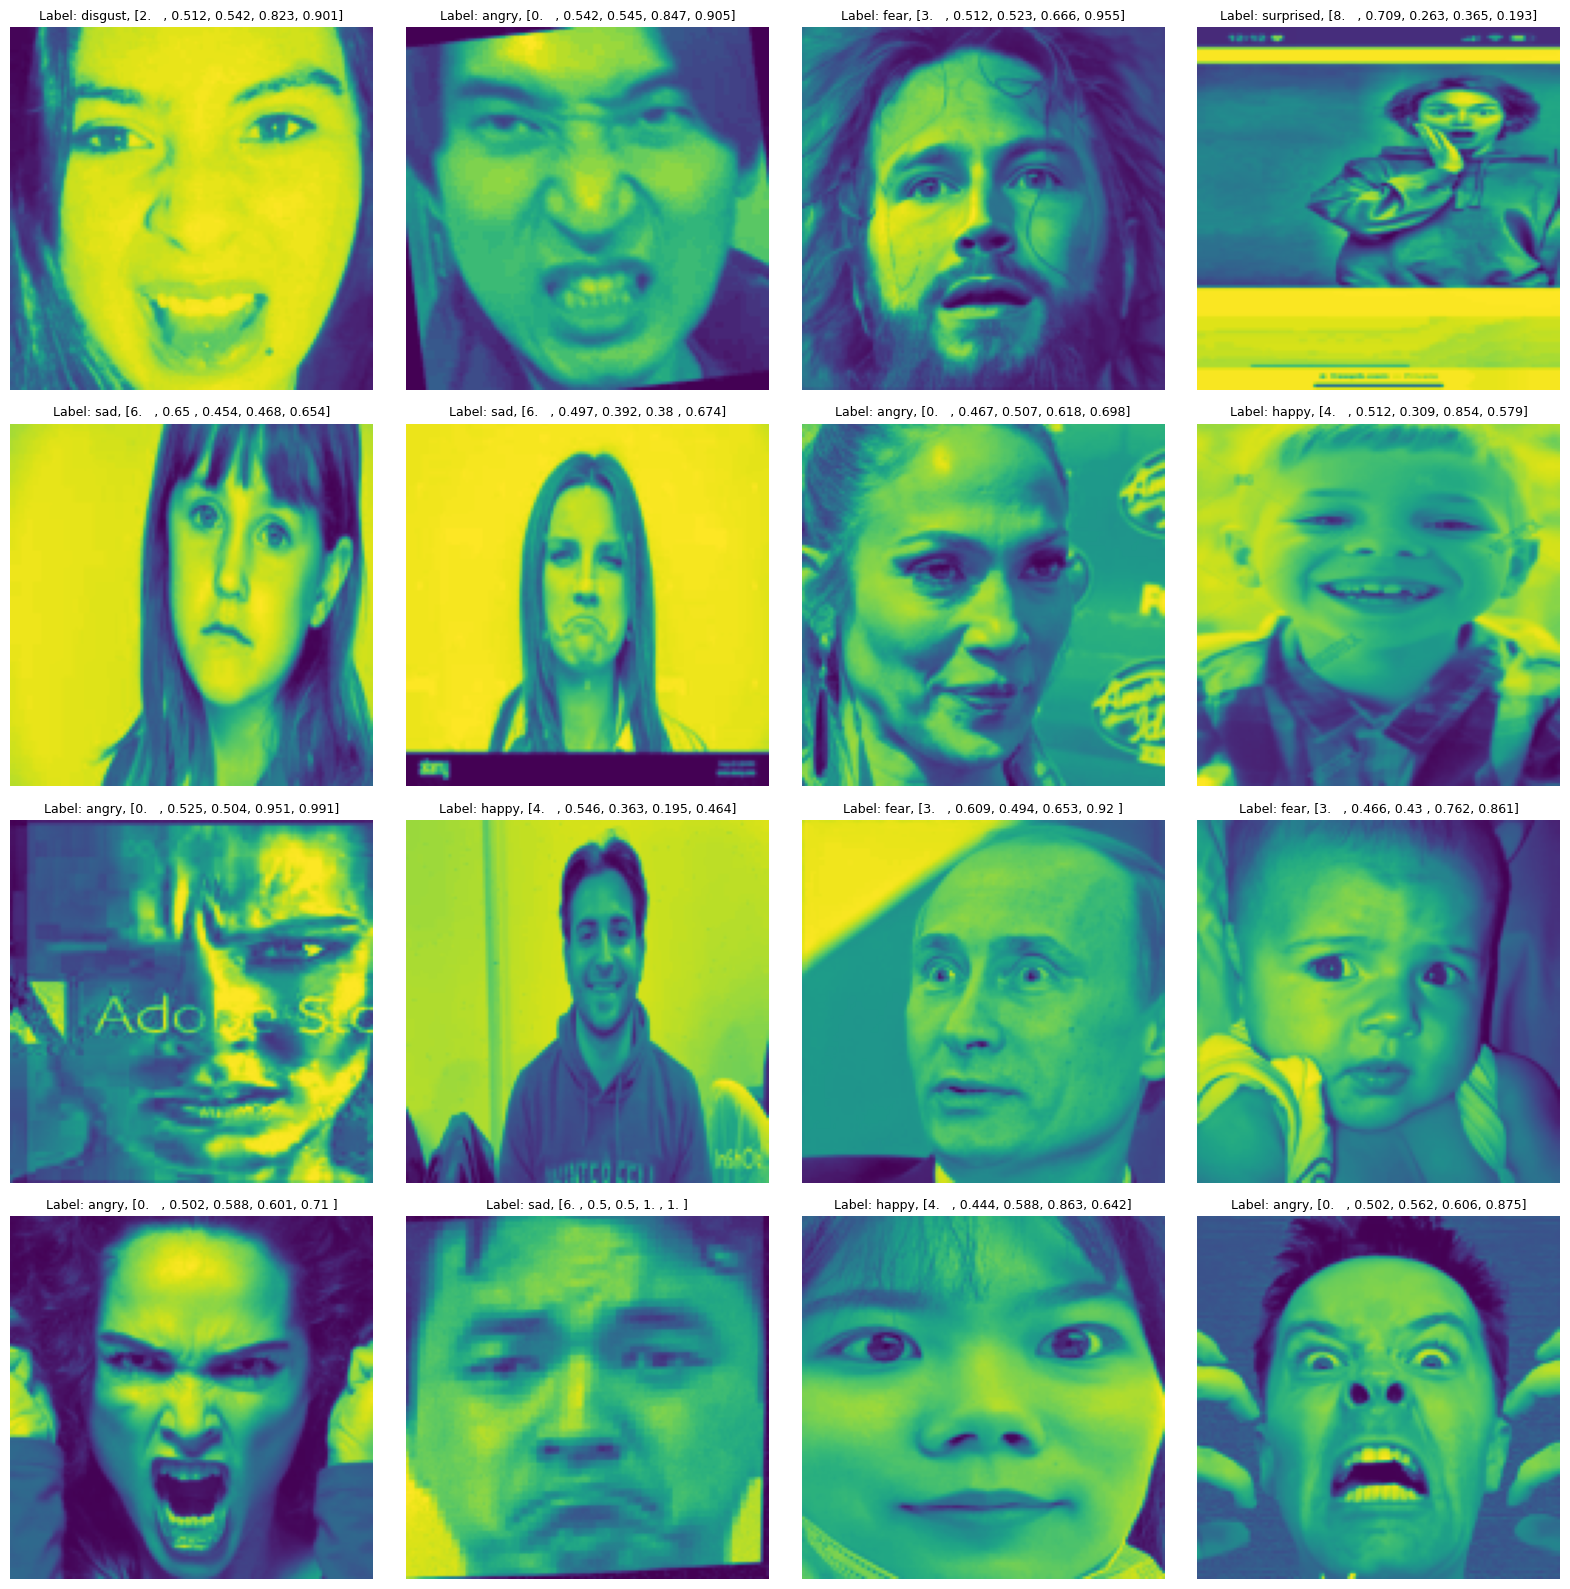

In [31]:
image, label = next(iter(orig_loader))
description = label_map[label[:,0].to(int)]
show_selected_images_labels(image,label,description)

Takeaways and Notes
===
- The dataset seems diverse: different resolutions, angles, greyscale vs color images ...
- Some images have clear facial expressions, while others are more ambiguous. Hence, we also would expect some ambiguity for our trained classifier.

Additional Points to Consider
---
- Better image preprocessing: consider resizing, cropping, or normalizing images to ensure consistency. This could also involve machine learning techniques.
- Class balancing: if some classes are underrepresented, consider oversampling or undersampling techniques to balance the dataset.

Next steps
---
To ease the following exercise at first we will simplify the classes. Instead of considering the nine original categories encoding different emotions we will group them into "bad" and "good" emotions and focus first on a binary classification problem. Afterwards, we will come back to the original dataset.

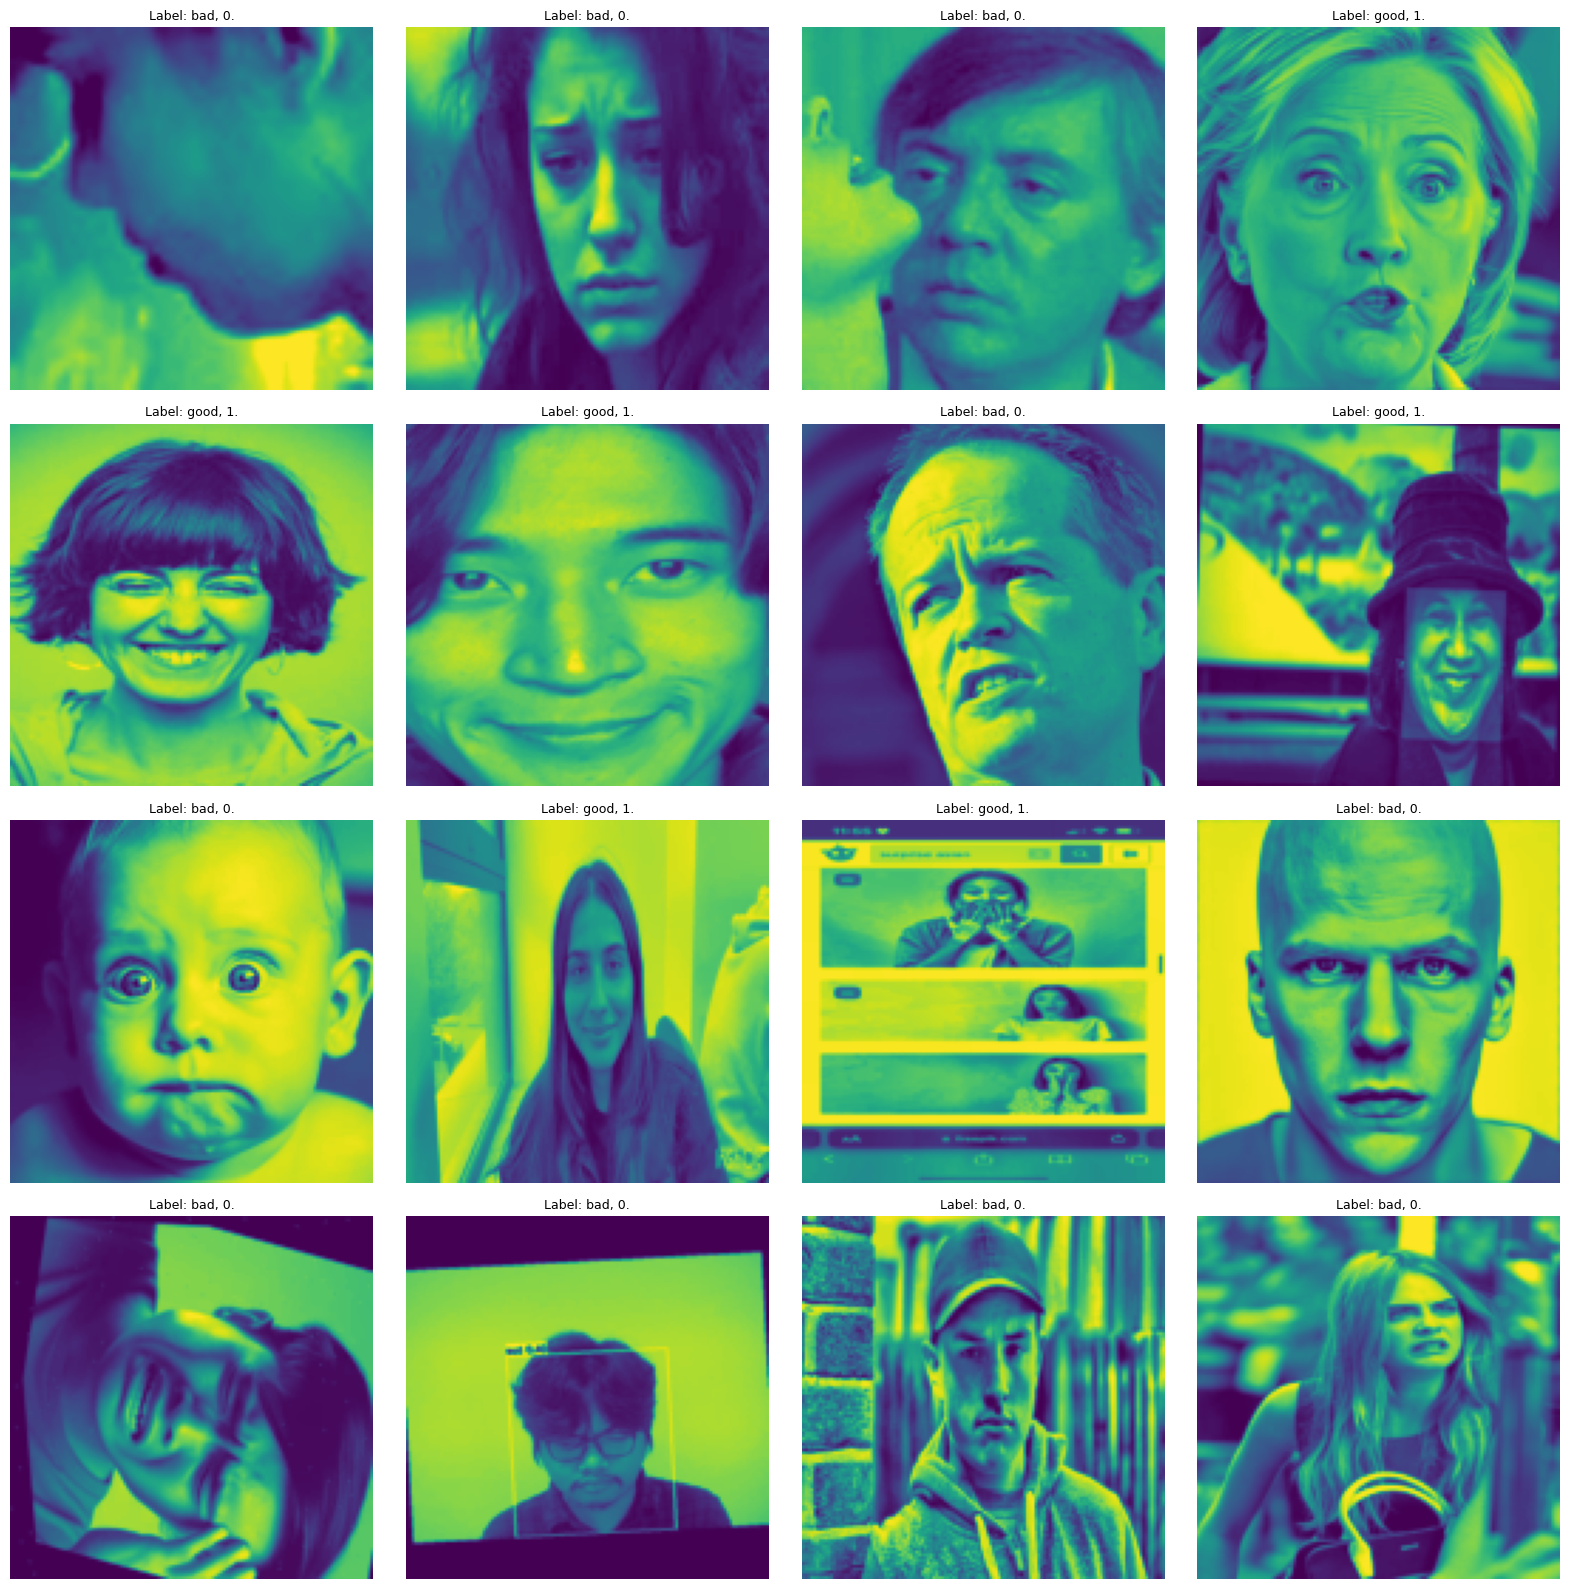

In [32]:
# original label map (9 classes): angry 0, contempt 1, disgust 2, fear 3, happy 4, neutral 5, sad 6, sleeps 7, surprised 8
# new label map (2 classes):      bad 0,   bad 0,      bad 0,     bad 0,  good 1,  good 1,    bad 0,  bad 0,   good 1
label_map_binary = np.array([
    "bad", "good"
])

def label_transform_binary(l):
    binary = torch.tensor(np.isin(l[0], [4,5,8]), dtype=torch.float32)
    return binary

train_dataset = ImageLabelDataset(train_dir + "/" + img_folder, train_dir + "/" + label_folder, img_transform=image_transform, label_transform=label_transform_binary)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

image, label = next(iter(train_loader))
description = label_map_binary[label.to(int)]
show_selected_images_labels(image,label,description)

The Bayesian Point of View - how to define our Classifier?
===
Let us start with the definition of our task:
> Given a *single* image of a face, we want to classify the facial expression into one of two emotion categories: good and bad emotion.

In more mathematical terms:
> Given a *single* image $x \in \mathbb{R}^{\text{width} \times \text{height}}$, we want to estimate the probabilities
$\mathbb{P}(x \text{ shows a bad emotion})$ and $\mathbb{P}(x \text{ shows a good emotion})$. Since in our case, an image can either show a good or a bad emotion, it suffices to estimate one probability, e.g. $p = \mathbb{P}(x \text{ shows a bad emotion})$. Afterwards, we immediately know the other probability since $\mathbb{P}(x \text{ shows a good emotion})=1-p$.

Even more mathematically:
> We want to learn a function $f: \mathbb{R}^{\text{width} \times \text{height}} \to [0,1]$ such that $f(x) \approx \mathbb{P}(x \text{ shows a bad emotion})$.

But why are we talking about probabilities?
---
Let us assume we have a coin. But instead of the outcomes "head" or "number" the sides of our coin shows the categories "bad emotion" and "good emotion". Also, we do not expect to have a "fair" coin - some emotions are more likely to be shown than others.
Basically, the analogy of tossing our coin is that we choose randomly one person of the whole world, look at her face, and either observe a "good" or "bad" emotion.
What is the probability that this person would show a bad emotion?

First answer: how should we know?

Second answer: let us use our dataset! Count all the pictures showing a bad emotion and divide by the total number of pictures - this gives us the sought probability.

In [33]:
N = len(train_dataset) # number of images in the dataset
bad_count = (train_dataset.get_all_labels() == 0).sum()
p_bad = bad_count / N
display(f"The probability of a randomly chosen image showing a bad emotion is {p_bad:.2f}.")

'The probability of a randomly chosen image showing a bad emotion is 0.56.'

So now let us toss our coin one more time and pic another person from the world. Let us name this person Alice.
Before looking at Alice's face, we can now say that there is a 56% chance that Alice shows a bad emotion - nice.

But now let us actually *look* at Alice's face. We see that she has really red cheeks, her eyebrows are furrowed, and her mouth is pressed together. It looks like she is angry - a bad emotion. But are we still believing that there is only a 56% chance that she *is* actually in a bad mood?

Updating the Probability
---
Before, we calculated $\mathbb{P}(\text{an image shows a bad emotion}) \approx 0.56$ where we did not refer to an actual image. Now, we have a particular image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ observed. Let us say a picture of Alice. We want to calculate the probability that Alice is in a bad mood, given the picture of her:
$$
\mathbb{P}(\text{Alice is showing a bad emotion} | \text{ a picture } x \text{ of Alices's face}) = ?
$$
The $$|\text{ a picture } x \text{ of Alices's face}$$ notation means that we now have this additional information of a picture of Alice.

Mixing in Neural Networks
---
How would we, as humans, decide if Alice *is* in a bad mood given the picture of her? We would conclude this because of the red cheeks, the eyebrows, her overall facial expression. The key idea:
> There are certain features in pictures of faces which indicate if the person is in a bad mood.

But what are this features? We could predefine certain features and hope that they indicate what we want like the position of the eyebrows. This is error prone and in many tasks impossible. If I chose the eye color only as the indicator for my classifier, it will never make a good job.

We want to learn the features from the data we have! We model our probability with a neural network.

Remember the function $f(x)\approx \mathbb{P}(x \text{ shows a bad emotion})$ from before? Our $f(x)$ exactly is our neural network. Because we like fancy symbols, we do not write $f(x)$ but use the notation $\mathcal N_\theta(x)\approx \mathbb{P}(x \text{ shows a bad emotion})$.

Convolutional Neural Networks
---
Our network $N_\theta(x)$ takes an image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ as input and gives us a probability as a number in $[0,1]$. Convolutional neural networks are exactly these type of networks which can reduce a whole image to a single number.

In [65]:
class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=0),  # (3, 128, 128) → (32, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (32, 64, 64)

            nn.Conv2d(32, 64, kernel_size=4, padding=0), # → (64, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (64, 32, 32)

            nn.Conv2d(64, 128, kernel_size=4, padding=0),# → (128, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # → (128, 16, 16)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                 # → (128 * 16 * 16,)
            nn.Linear(128 * 13 * 13, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()                                  # Output ∈ [0, 1]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

CNN = BinaryClassifierCNN()

The Sigmoid Function
---
The last function of our network is the so-called sigmoid function
$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$
In 1D, $\sigma: \mathbb R \longrightarrow [0,1]$ which means in our case that $\sigma(t)$ can be interpreted as a probability!

Note however that $t \in \mathbb R$ here does not represent an image! Rather, $t$ is already an intermediate output of our neural network, which transformed an input image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ to some arbitrary real number $t \in \mathbb R$ and then applies on top $\sigma(t)$ to get something in $[0,1]$.

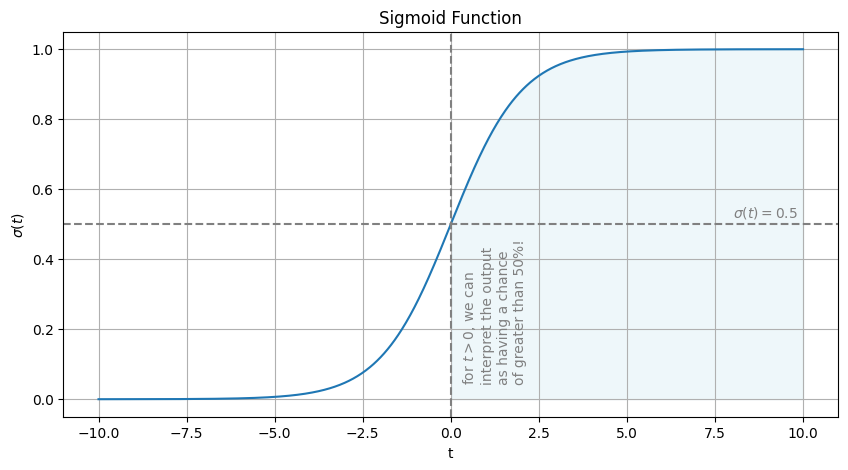

In [66]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Input range
t = np.linspace(-10, 10, 1000)
y = sigmoid(t)

# Plot
plt.figure(figsize=(10,5))
plt.plot(t, y)
plt.title("Sigmoid Function")
plt.xlabel("t")
plt.ylabel(r"$\sigma(t)$")
plt.grid(True)
plt.axhline(0.5, color='gray', linestyle='--')  # Midline
plt.axvline(0, color='gray', linestyle='--')    # Center point

# Annotate horizontal line
plt.text(8, 0.52, r"$\sigma(t)=0.5$", color='gray', fontsize=10)

# Annotate vertical line
plt.text(0.3, 0.05, 'for $t > 0$, we can \ninterpret the output \nas having a chance \nof greater than 50%!', color='gray', fontsize=10, rotation=90)

plt.fill_between(t, y, where=(t >= 0), color='lightblue', alpha=0.2, label=r'Area: $x \geq 0$')


plt.show()

Testing our Neural Network *before Training*
---
We can already plug in some images into our neural network and see what we get.

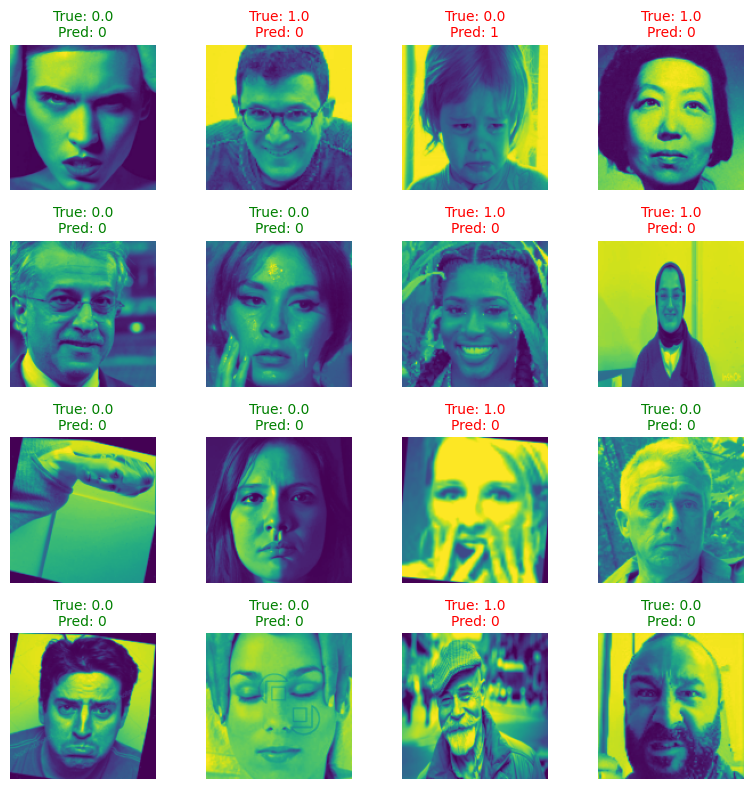

Correctly classified:  18
Wrongly classified:  14


In [67]:
def visualize_binary_predictions(x_test, y_test, y_pred, rows=3, cols=3):

    true_labels = y_test
    images = x_test
    pred_labels = y_pred

    num_images = images.shape[0]
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < num_images:
            ax = axes[i]
            img = images[i,:].permute(1, 2, 0).numpy()
            true_label = true_labels[i].item()
            pred_label = pred_labels[i].item()

            # Show the image
            ax.imshow(img, cmap='gray_r' if img.ndim == 2 else None)
            ax.axis("off")

            # Set title with correct or incorrect prediction
            title_color = "green" if true_labels[i] == pred_labels[i] else "red"
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=title_color)

    plt.tight_layout()
    plt.show()

image, label = next(iter(train_loader))
y_true = label.detach().cpu().numpy().reshape(-1,1)
y_pred = (CNN(image).detach().cpu().numpy() < 0.5).astype(int)

visualize_binary_predictions(image, y_true, y_pred, rows=4, cols=4)

true_count = y_true == y_pred
false_count = y_true != y_pred
print("Correctly classified: ", np.sum(true_count))
print("Wrongly classified: ", np.sum(false_count))

Training our Neural Network
===

So far it does not look like our network "knows" anything on how to classify correctly the people's moods. Rather, it seems to randomly guess the mood state. We need to tell the network somehow how people with bad mood look like.

Learning by Examples
---
How did you "learn" how people in bad mood look like? I guess you have already seen enough angry, sad, tired, ... people to know how they look. But not only this. When you really learned about the emotions like "This is Alice. She is angry." you learned somehow from labelled data (you saw Alice's face with a description on her emotions) and then were able to generalise to knew faces. This is exactly what we are now doing with our neural network.

In [68]:
loss_func = nn.BCELoss()
pars = CNN.parameters()
optimizer = torch.optim.Adam(pars, lr=0.01, weight_decay=0.001)

train_dataset = ImageLabelDataset(train_dir + "/" + img_folder, train_dir + "/" + label_folder, img_transform=image_transform, label_transform=label_transform_binary)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [69]:
epochs = 5000

show_every = 50 #how often to show the loss
ob_val = np.zeros(epochs)

CNN.train() # set to training mode

for epoch in range(epochs):  # loop over the dataset multiple times

    for i, (images, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Evaluate the loss and carry out gradient descent step
        loss = loss_func(CNN(images).squeeze(),labels)
        loss.backward()
        optimizer.step()

        # print loss
        ob_val[i] = loss.item()
        if np.remainder(i,show_every)==0:
            print('Batch: ' + str(i) + ', Loss: ' + str(ob_val[i]))

            with torch.no_grad():
                preds = CNN(images).squeeze()
                predicted_labels = (preds > 0.5).float()
                accuracy = (predicted_labels == labels).float().mean()
                print(f"Accuracy: {accuracy:.4f}")


print('Finished Training')

Batch: 0, Loss: 0.6973699331283569
Accuracy: 0.7500
Batch: 50, Loss: 0.6636468768119812
Accuracy: 0.5938
Batch: 100, Loss: 0.6989094018936157
Accuracy: 0.5312
Batch: 150, Loss: 0.6915386915206909
Accuracy: 0.5312
Batch: 200, Loss: 0.6880743503570557
Accuracy: 0.5625
Batch: 250, Loss: 0.6809654235839844
Accuracy: 0.5938
Batch: 300, Loss: 0.6805709600448608
Accuracy: 0.5938
Batch: 350, Loss: 0.685349702835083
Accuracy: 0.5625
Batch: 400, Loss: 0.7041996717453003
Accuracy: 0.5000
Batch: 450, Loss: 0.7168249487876892
Accuracy: 0.4688
Batch: 500, Loss: 0.6978513598442078
Accuracy: 0.5000
Batch: 550, Loss: 0.6925786733627319
Accuracy: 0.5312
Batch: 600, Loss: 0.703586220741272
Accuracy: 0.5000
Batch: 650, Loss: 0.6545295715332031
Accuracy: 0.7188
Batch: 700, Loss: 0.6272194981575012
Accuracy: 0.7812
Batch: 750, Loss: 0.7038062810897827
Accuracy: 0.4062
Batch: 800, Loss: 0.6890000104904175
Accuracy: 0.5312
Batch: 850, Loss: 0.72148597240448
Accuracy: 0.4062
Batch: 900, Loss: 0.709758877754211

KeyboardInterrupt: 

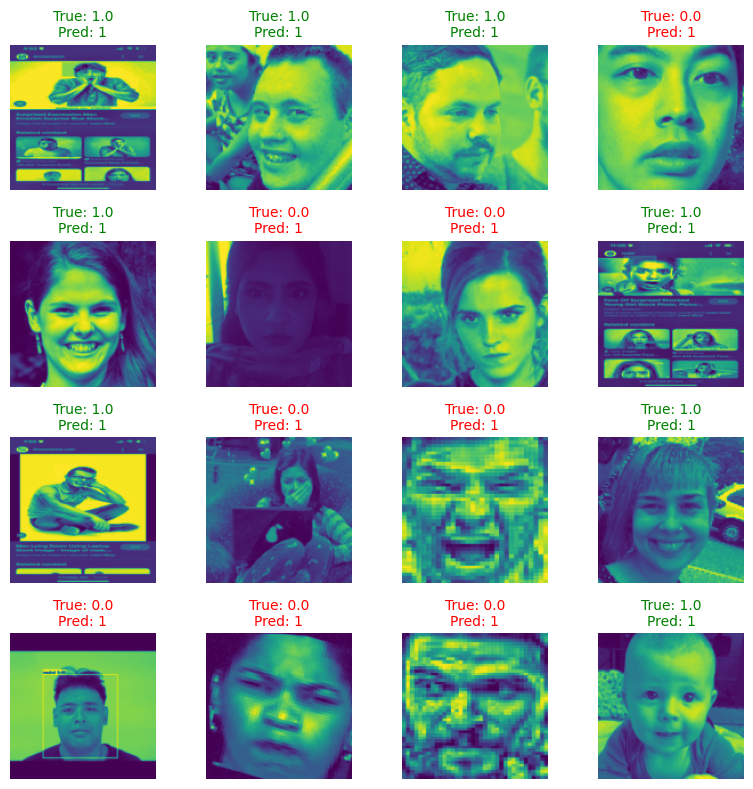

Correctly classified:  8
Wrongly classified:  8


In [39]:
image, label = next(iter(train_loader))
y_true = label.detach().cpu().numpy().reshape(-1,1)
y_pred = (CNN(image).detach().cpu().numpy() < 0.5).astype(int)

visualize_binary_predictions(image, y_true, y_pred, rows=4, cols=4)

true_count = y_true == y_pred
false_count = y_true != y_pred
print("Correctly classified: ", np.sum(true_count))
print("Wrongly classified: ", np.sum(false_count))